# Customer Personality Analysis

## Table of contents
1. [Dataset](#introduction)
2. [Exploratory Data Analysis](#paragraph1)
3. [Refining the data](#paragraph2)
4. [Classification](#)
5. [Model Comparison](#)

## 1. Dataset

Attributes

People

 - ID: Customer's unique identifier
 - Year_Birth: Customer's birth year
 - Education: Customer's education level
 - Marital_Status: Customer's marital status
 - Income: Customer's yearly household income
 - Kidhome: Number of children in customer's household
 - Teenhome: Number of teenagers in customer's household
 - Dt_Customer: Date of customer's enrollment with the company
 - Recency: Number of days since customer's last purchase
 - Complain: 1 if the customer complained in the last 2 years, 0 otherwise


Products

 - MntWines: Amount spent on wine in last 2 years
 - MntFruits: Amount spent on fruits in last 2 years
 - MntMeatProducts: Amount spent on meat in last 2 years
 - MntFishProducts: Amount spent on fish in last 2 years
 - MntSweetProducts: Amount spent on sweets in last 2 years
 - MntGoldProds: Amount spent on gold in last 2 years


Promotion

 - NumDealsPurchases: Number of purchases made with a discount
 - AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
 - AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
 - AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
 - AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
 - AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
 - Response: 1 if customer accepted the offer in the last campaign, 0 otherwise


Place
 - NumWebPurchases: Number of purchases made through the company’s website
 - NumCatalogPurchases: Number of purchases made using a catalogue
 - NumStorePurchases: Number of purchases made directly in stores
 - NumWebVisitsMonth: Number of visits to company’s website in the last month


Target
Need to perform clustering to summarize customer segments.

Acknowledgement
The dataset for this project is provided by Dr. Omar Romero - Hernandez.

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import warnings
import sys


In [60]:
os.environ["OMP_NUM_THREADS"] = '9' # To prevent memory-leakage in Windows
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [61]:
plt.style.use('ggplot')

In [62]:
df = pd.read_csv("data//marketing_campaign.csv",index_col=0,delimiter="\t")

In [63]:
print(df.describe().T)

                      count          mean           std     min       25%  \
Year_Birth           2240.0   1968.805804     11.984069  1893.0   1959.00   
Income               2216.0  52247.251354  25173.076661  1730.0  35303.00   
Kidhome              2240.0      0.444196      0.538398     0.0      0.00   
Teenhome             2240.0      0.506250      0.544538     0.0      0.00   
Recency              2240.0     49.109375     28.962453     0.0     24.00   
MntWines             2240.0    303.935714    336.597393     0.0     23.75   
MntFruits            2240.0     26.302232     39.773434     0.0      1.00   
MntMeatProducts      2240.0    166.950000    225.715373     0.0     16.00   
MntFishProducts      2240.0     37.525446     54.628979     0.0      3.00   
MntSweetProducts     2240.0     27.062946     41.280498     0.0      1.00   
MntGoldProds         2240.0     44.021875     52.167439     0.0      9.00   
NumDealsPurchases    2240.0      2.325000      1.932238     0.0      1.00   

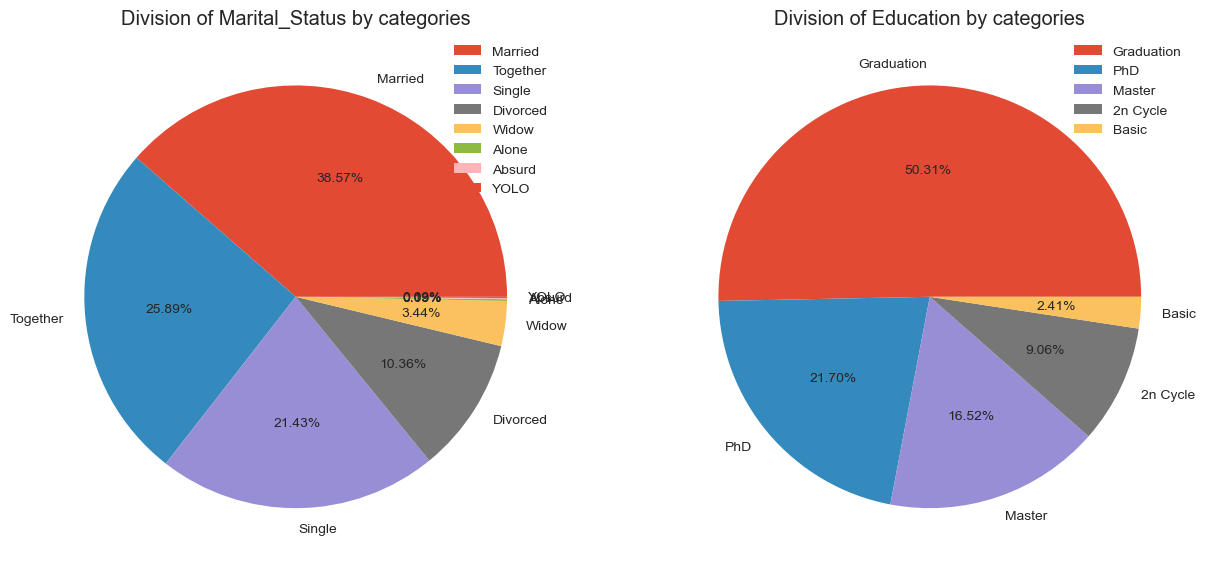

In [115]:
%matplotlib inline

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10))

wedges, texts, autotexts  =ax1.pie(df["Marital_Status"].value_counts().values,labels=df["Marital_Status"].value_counts().index.tolist(),autopct='%.2f%%')
wedges, texts, autotexts  =ax2.pie(df["Education"].value_counts().values,labels=df["Education"].value_counts().index.tolist(),autopct='%.2f%%')
ax1.legend(loc=1)
ax2.legend(loc=1)
ax1.set_title("Division of Marital_Status by categories")
ax2.set_title("Division of Education by categories")

plt.show()

In [65]:
quantitative = [c for c in df.columns if df.dtypes[c] != 'object']
qualitative = [c for c in df.columns if df.dtypes[c] == 'object']


In [66]:
missing_values = pd.isnull(df).sum().sort_values(ascending=True)
print(missing_values[missing_values>0])

Income    24
dtype: int64


## Refining data

Remove Nan Values

In [67]:
filtered_df = df.copy()
filtered_df = filtered_df.dropna(axis=0)
print("{:.0f} data-points dropped because of Nan values".format(len(df)-len(filtered_df)))

24 data-points dropped because of Nan values


### Remove outliers with z-score greater than 2 in continuous columns

In [68]:

before = len(filtered_df)
for c in ["Income","Year_Birth"]:
    filtered_df = filtered_df[np.abs(filtered_df[c]-df[c].mean()) <= (2*filtered_df[c].std())]
print("{:.0f} data-points dropped because of Z-scores greater than 2".format(before-len(filtered_df)))

45 data-points dropped because of Z-scores greater than 2


In [69]:

filtered_df["Dt_Customer"] = pd.to_datetime(filtered_df["Dt_Customer"], format="%d-%m-%Y")

    


basedate = max(filtered_df["Dt_Customer"])
baseyear = 2014

filtered_df["days_since_customer"] = filtered_df["Dt_Customer"].apply(lambda x: (basedate-x).days)
filtered_df["age_years"] = filtered_df["Year_Birth"].apply(lambda x: (baseyear-x))


In [70]:
filtered_df.drop(["Dt_Customer","Year_Birth"],axis=1,inplace=True)

## 

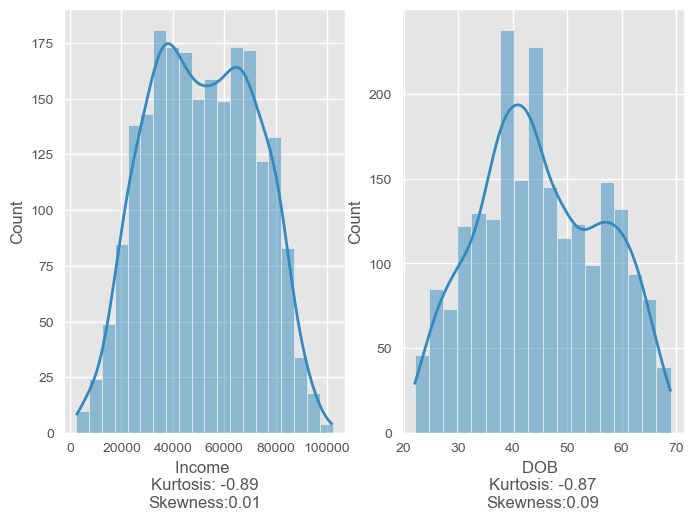

In [71]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(filtered_df["Income"],kde=True,ax=ax1)
sns.histplot(filtered_df["age_years"],kde=True,ax=ax2)
ax1.set_xlabel("Income \nKurtosis: {:.2f}\nSkewness:{:.2f}".format(filtered_df["Income"].kurt(),filtered_df["Income"].skew()))
ax2.set_xlabel("DOB \nKurtosis: {:.2f}\nSkewness:{:.2f}".format(filtered_df["age_years"].kurt(),filtered_df["age_years"].skew()))
plt.show()

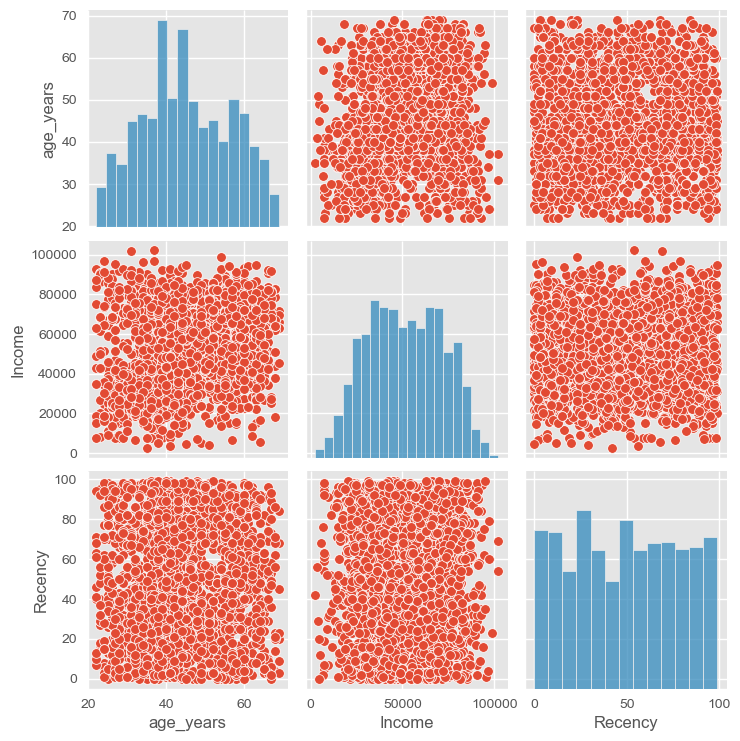

In [72]:
vars_corr = ["age_years","Income","Recency"]
sns.pairplot(filtered_df[vars_corr])
plt.show()

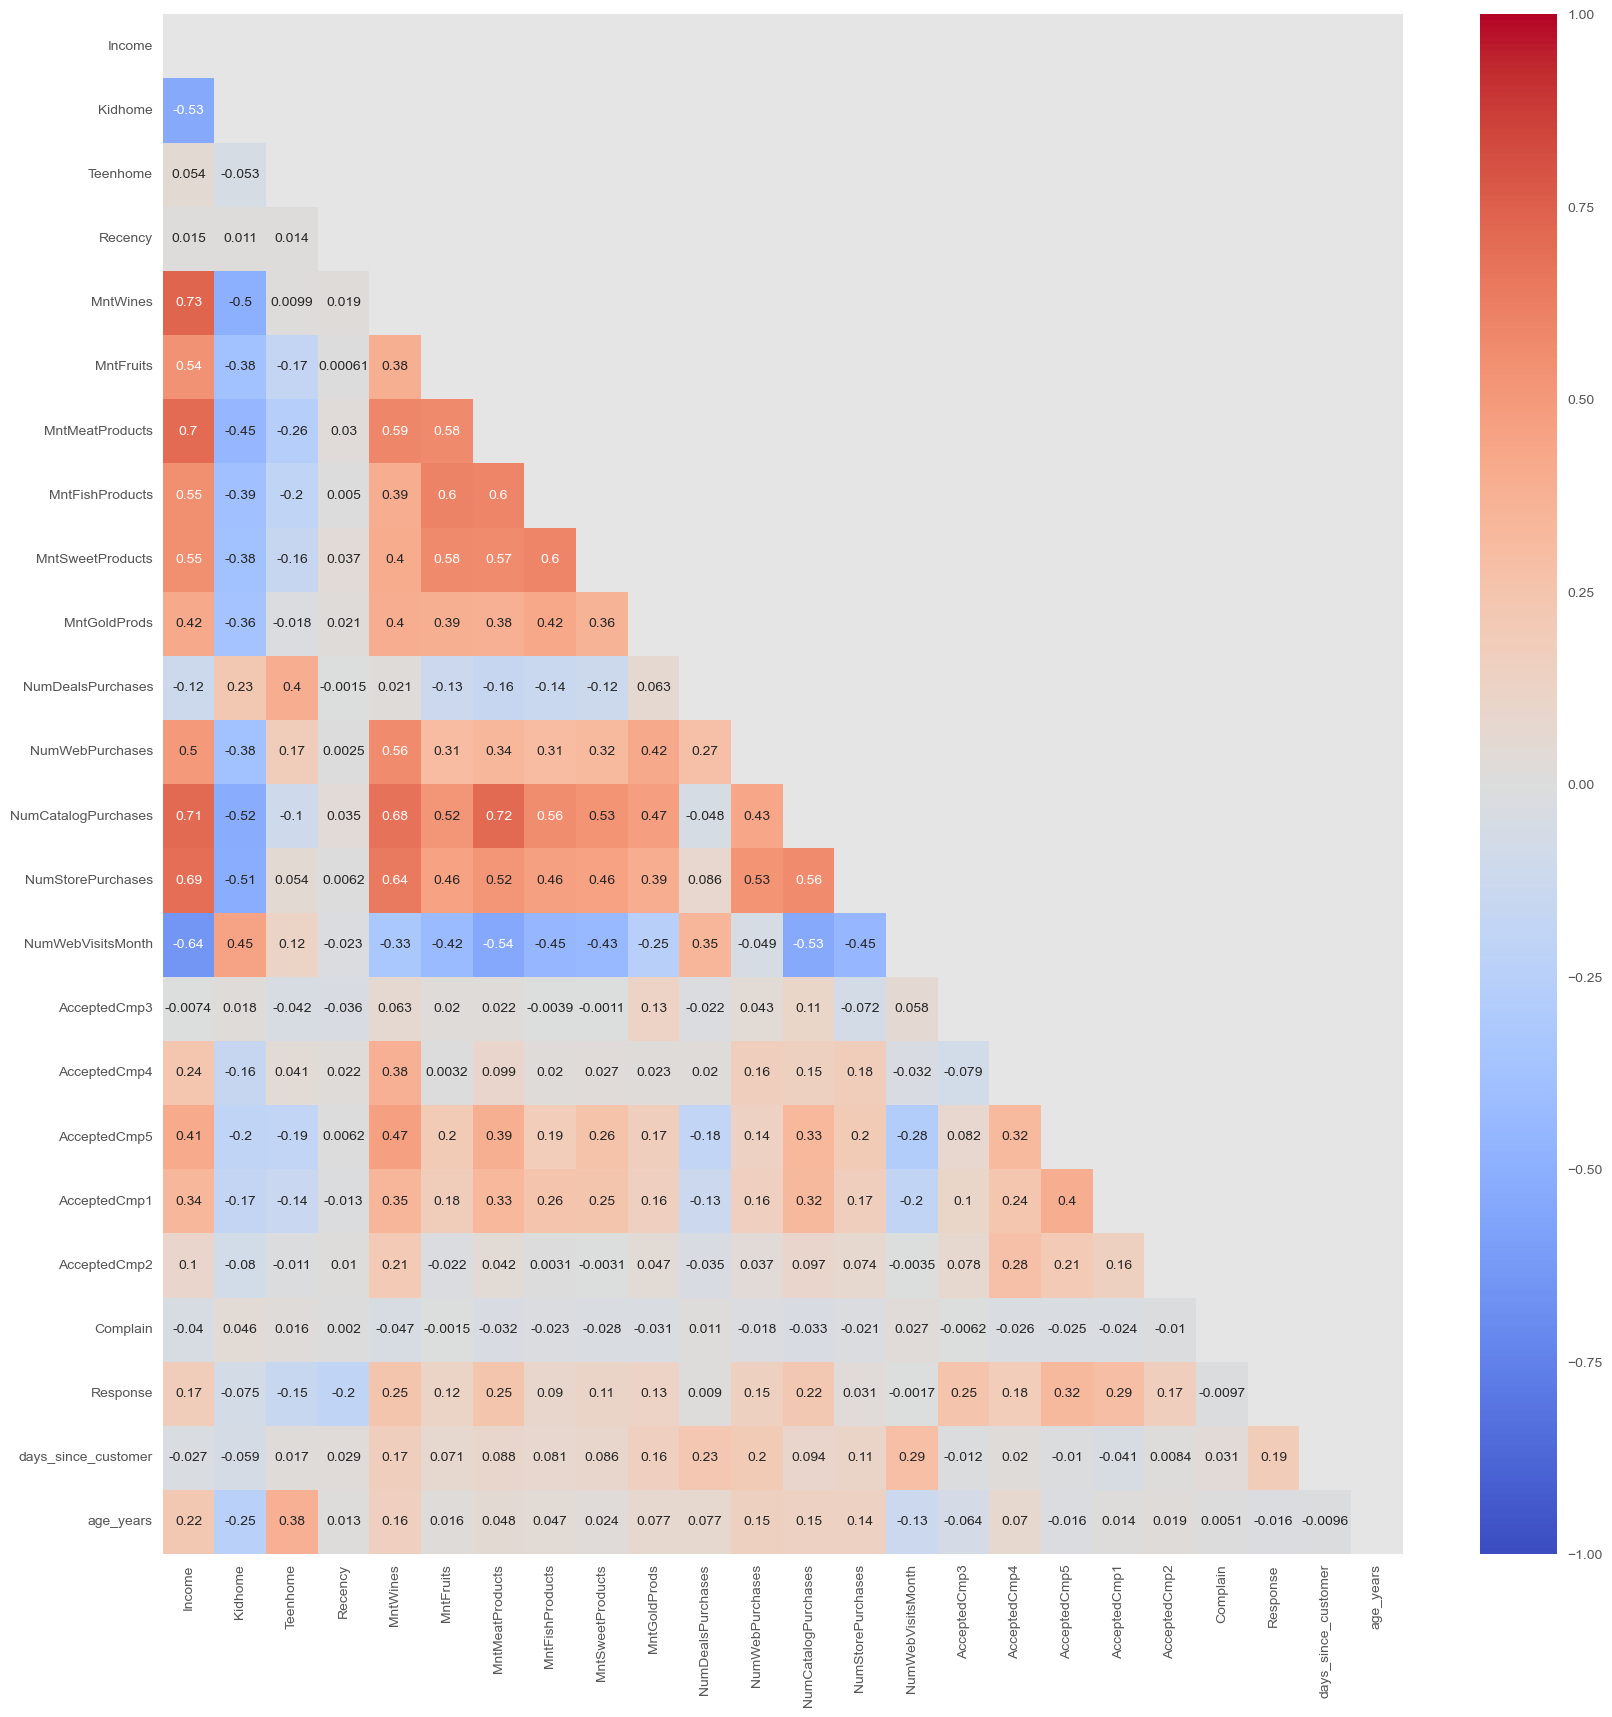

In [73]:
df_corr = filtered_df.loc[:, ~filtered_df.columns.isin(['Z_CostContact',"Z_Revenue"])].corr()
# print(df_corr)
fig= plt.figure(figsize=(20,20))
mask = np.triu(df_corr)
sns.heatmap(df_corr,annot=True,mask=mask,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
# fig.set_title("Correlation of variables")
plt.show()

### Encoding categorical variables

In [74]:
filtered_df = pd.get_dummies(filtered_df, columns=["Marital_Status","Education"],prefix="_")

### Standard Scaling Features

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_mat = scaler.fit_transform(filtered_df)
scaled_df = pd.DataFrame(columns=filtered_df.columns,data=scaled_mat)
# print(scaled_df)

#### Conclusion:

- 45 outliers removed based on income/birth-year.
- 24 data-points removed for NaN values
- Skewness and kurtosis negligible for Income and Birth-year
**Positive Correlations:**
  
    - Income-MntWines : 0.73
    - NumCatalogPurchases-MntMeatProducts: 0.72
    - NumCatalogPurchases-Income: 0.71
    - Income - MntMeatProducts: 0.7


 **Negative Correlations:**
    - NumWebVisits - Income: -0.64
    - NumWebVisits - MntMeatProducts: -0.54
    - KidHome - Income: -0.53
    - NumWebVisits - NumCatalogPurchases: -0.53


## Principal Component Analysis

In [76]:
pca = PCA(n_components=3)
pca.fit(scaled_df)
pca_df = pd.DataFrame(pca.transform(scaled_df),columns=["feature1","feature2","feature3"])


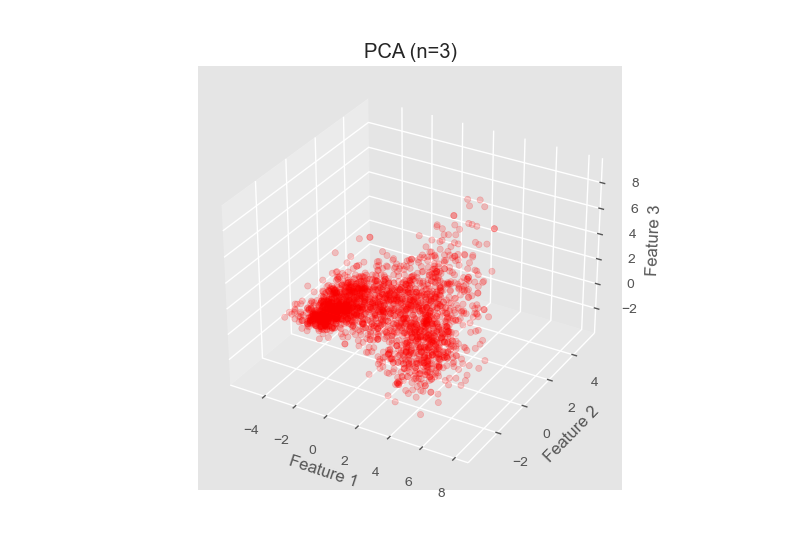

In [77]:
%matplotlib widget
# creating figure
xs=pca_df["feature1"]
ys=pca_df["feature2"]
zs=pca_df["feature3"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
  
# creating the plot
ax.scatter3D(xs, ys, zs, color='red',alpha=0.2)
  
# setting title and labels
ax.set_title("PCA (n=3)")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
  
# displaying the plot
plt.show()

## 4. Classification

In [78]:
K = range(1,10)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_df)
    distortions.append(kmeanModel.inertia_)

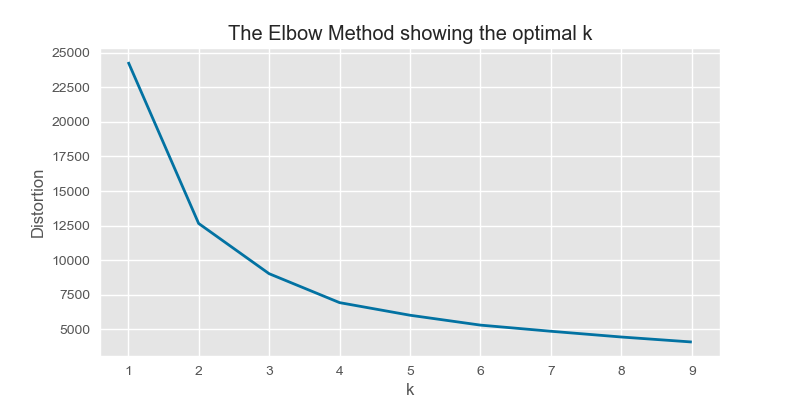

In [79]:
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [80]:
AC = AgglomerativeClustering(n_clusters=4)
yhat_AC = AC.fit_predict(pca_df)
pca_df["Clusters"] = yhat_AC
filtered_df["Clusters"]= yhat_AC

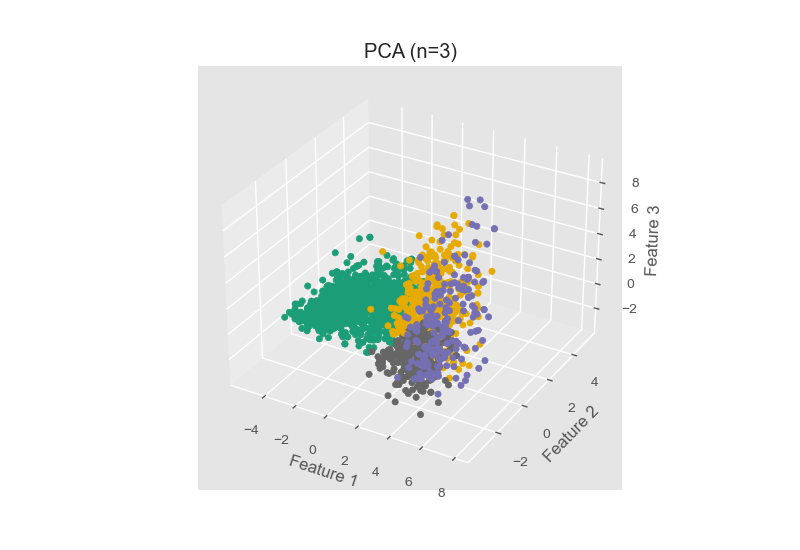

In [81]:
%matplotlib widget
# creating figure
xs=pca_df["feature1"]
ys=pca_df["feature2"]
zs=pca_df["feature3"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
COLORS = ["#003f5c","#58508d","#bc5090","#ff6361","#ffa600"]
# creating the plot
ax.scatter3D(xs, ys, zs, c=filtered_df["Clusters"],alpha=1,cmap="Dark2")

# setting title and labels
ax.set_title("PCA (n=3)")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
  
# displaying the plot
plt.show()

## Analysis

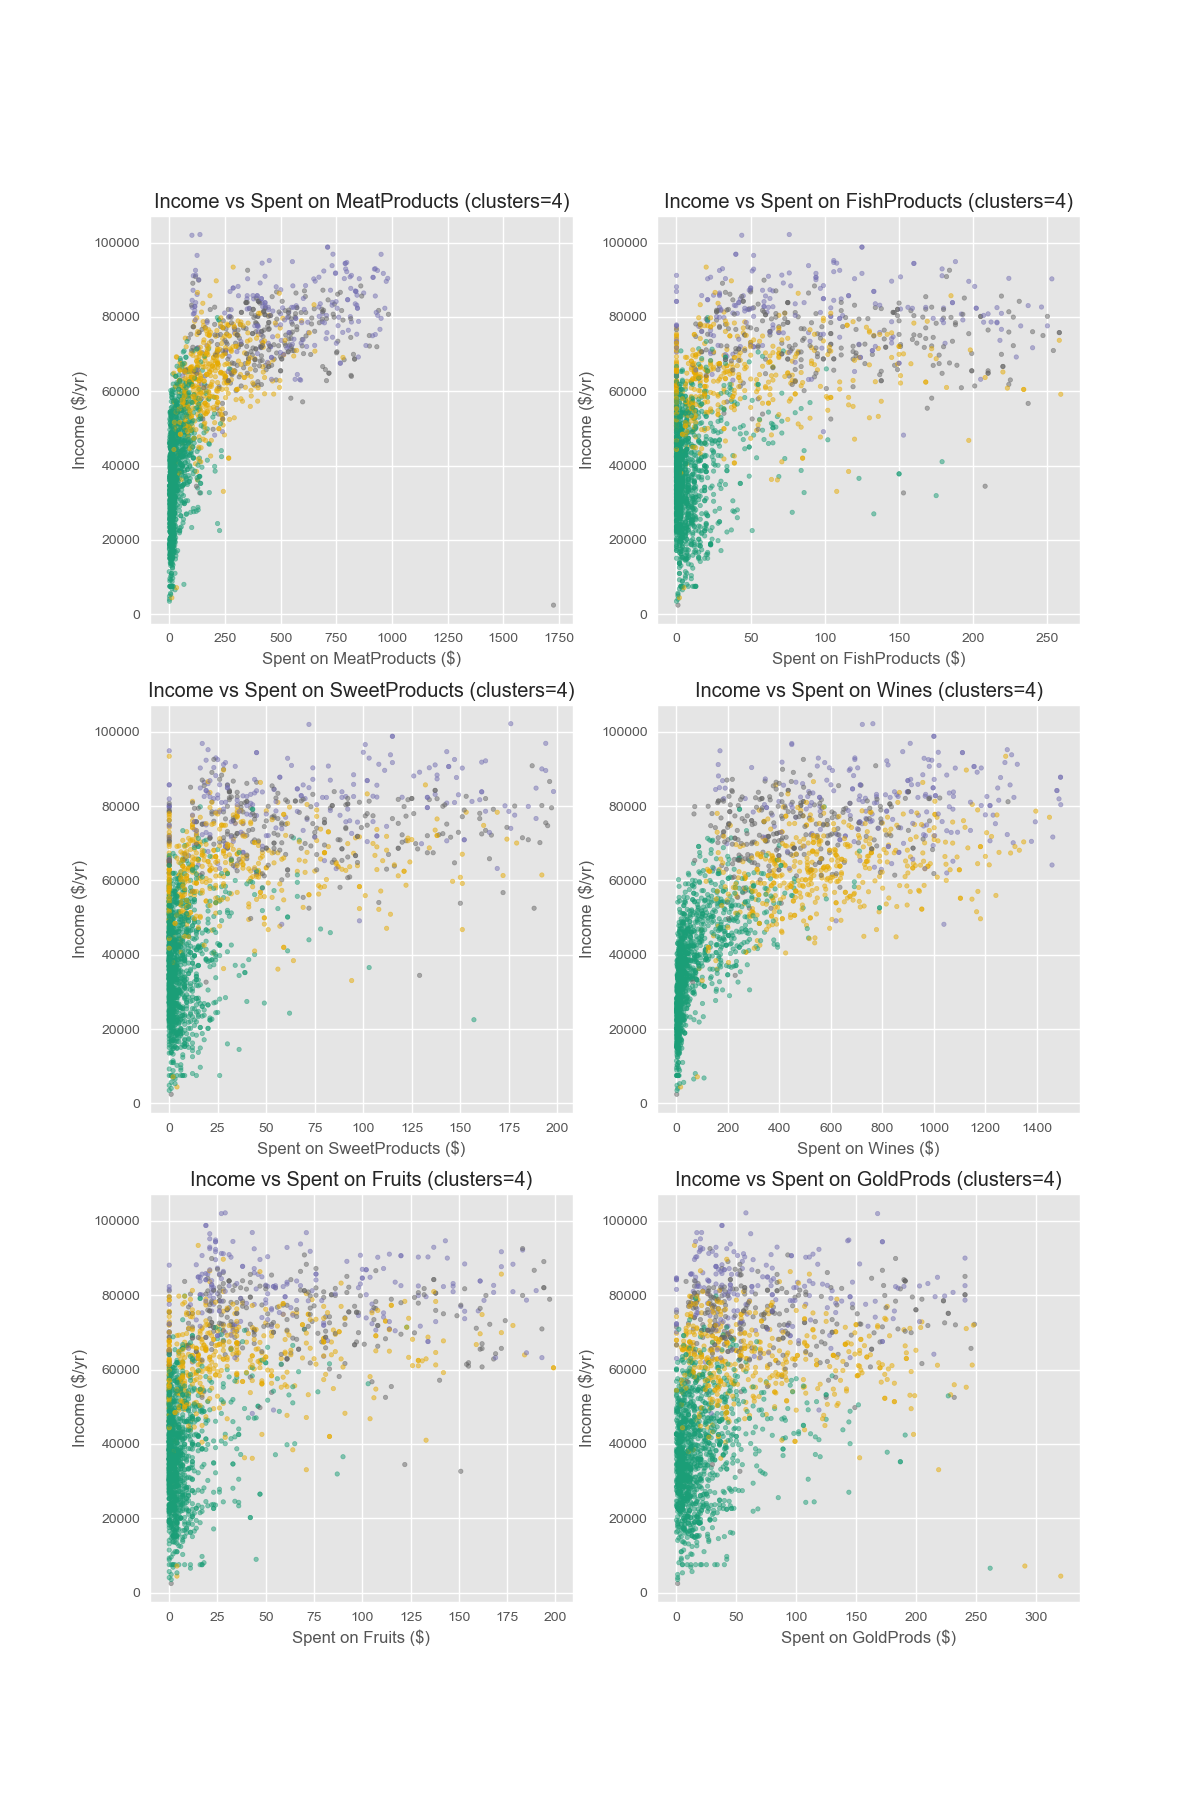

In [82]:
nrows = 3
ncols=2

fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(12,18))
spending_category = ["MntMeatProducts","MntWines","MntFruits","MntFishProducts","MntSweetProducts","MntGoldProds"]
for i,cat in enumerate(spending_category):
    axs[i%nrows,i%ncols].scatter(filtered_df[spending_category[i]],filtered_df["Income"],c=filtered_df["Clusters"],cmap="Dark2",s=10,alpha=0.5)
    axs[i%nrows,i%ncols].set_ylabel("Income ($/yr)")
    axs[i%nrows,i%ncols].set_xlabel("Spent on {} ($)".format(cat[3:]))
    axs[i%nrows,i%ncols].set_title("Income vs Spent on {} (clusters=4)".format(cat[3:]))
    


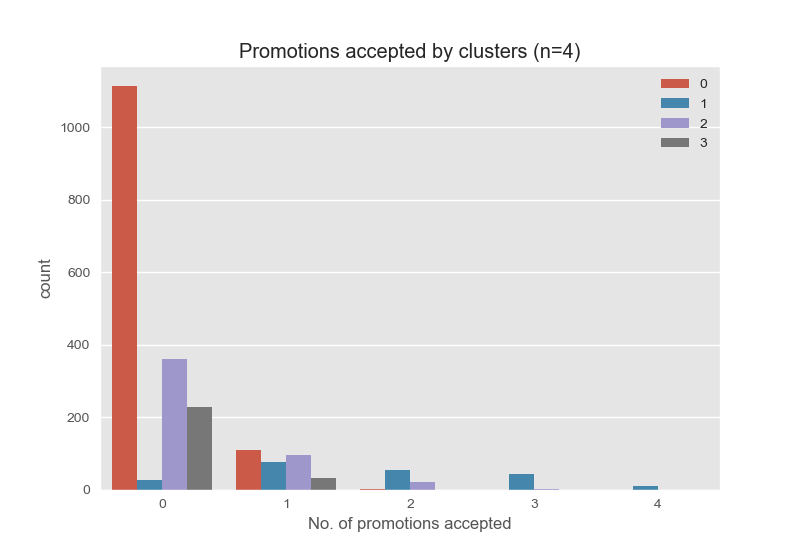

In [99]:
filtered_df["no_promotions"] = filtered_df[["AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5"]].sum(axis=1)
fig,ax = plt.subplots()
ax =sns.countplot(x=filtered_df["no_promotions"],hue=filtered_df["Clusters"])
ax.set_title("Promotions accepted by clusters (n=4)")
ax.set_xlabel("No. of promotions accepted")
ax.legend(loc=1)
plt.show()

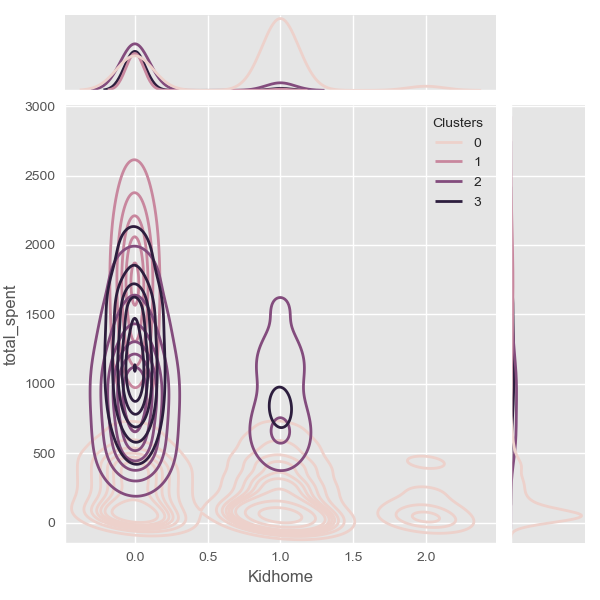

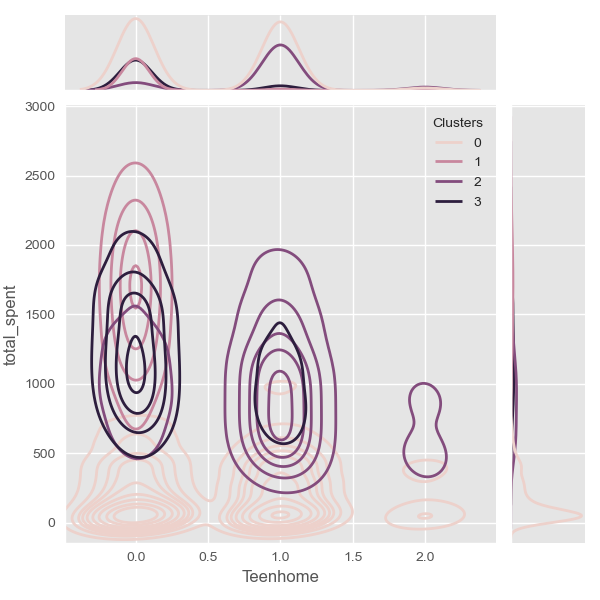

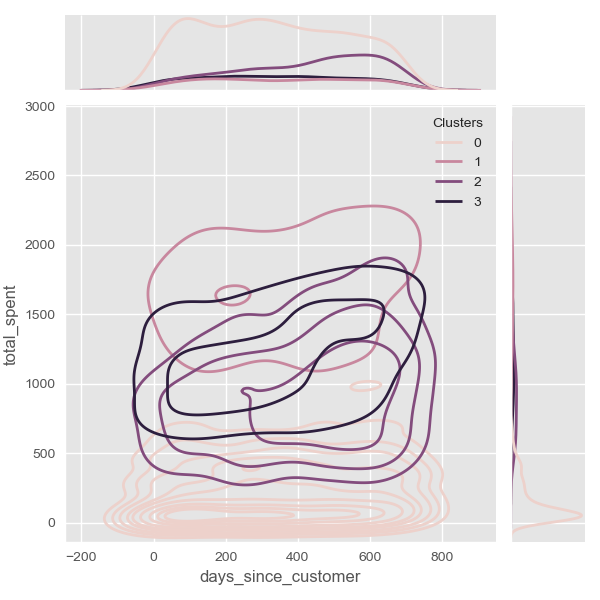

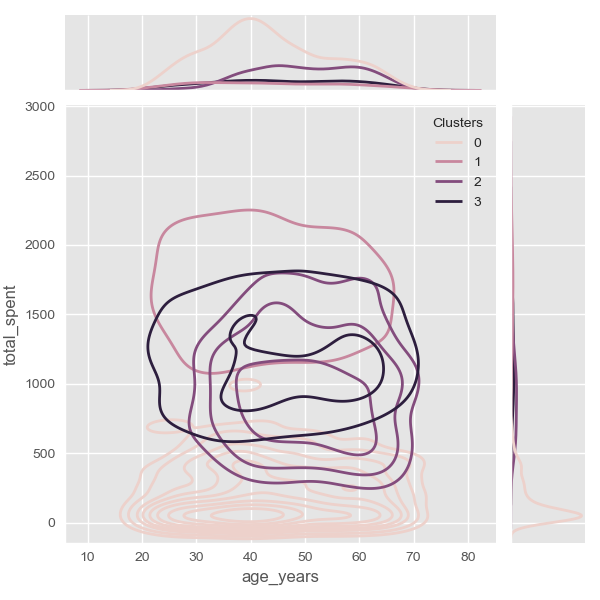

In [114]:

filtered_df["total_spent"] = filtered_df[spending_category].sum(axis=1)
base_category = [ "Kidhome","Teenhome","days_since_customer", "age_years"]
for i,cat in enumerate(base_category):
    sns.jointplot(x=filtered_df[cat], y=filtered_df["total_spent"], hue =filtered_df["Clusters"], kind="kde")
    plt.show()
 
    
